In [1]:
import networkx as nx
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

### Import stats data

In [3]:
seasonstats = pd.read_csv("../data/season_1/stats_season_1.csv")

In [182]:
(seasonstats.columns)

Index(['Season', 'Episode', 'Contestants', 'ChW', 'ChA', 'SO', 'VFB', 'VAP',
       'TotV', 'TCA', 'TCV', 'VFT', 'InRCA', 'InRCW', 'InICA', 'InICW', 'TRCA',
       'TRCW', 'TICA', 'TICW', 'Reward win?', 'Reward #people', 'Reward win%',
       'Immunity win', 'Immunity #people', 'Immunity win%',
       'Immunity total win%', 'Sex', 'Age', 'Occupation', 'Hometown',
       'Home State', 'Original Tribe', 'Merged', 'Tribe'],
      dtype='object')

In [316]:
def plotMerged(seasonstats):
    epList = seasonstats[(seasonstats['Merged'] == True)]['Episode'].unique()
    season = str(seasonstats['Season'].unique()[0])
    tribeName = seasonstats[(seasonstats['Merged'] == True)]['Tribe'].unique()[0]
    lastEp = max(epList)
    
    for i in range(len(epList)):
        if epList[i] != lastEp:
            ep = epList[i]
            tribalVotes = seasonstats[(seasonstats['Merged'] == True) & (seasonstats['Episode'] == ep)][['Contestants','TCV']]
            indvVotes = list(tribalVotes.itertuples(index=False, name=None))

            fig = plt.figure(figsize=(15, 6))

            G = nx.DiGraph()
            G.add_edges_from(indvVotes)
            nx.draw(G, with_labels=True)
            fig.suptitle(tribeName + " Tribe")
            plt.title('Survivor Season ' + season + ' Episode ' + str(ep))
            plt.show()
        else:
            ep = epList[i]
            tribalVotes = seasonstats[(seasonstats['Merged'] == True) & (seasonstats['Episode'] == ep)][['Contestants','TCV']]
            indvVotes = list(tribalVotes.itertuples(index=False, name=None))
            e = []
            
            for i in range(len(indvVotes)):
                if str(indvVotes[i][1]) != 'nan':
                    e.append(indvVotes[i])

            n = seasonstats[(seasonstats['Merged'] == True) & (seasonstats['Episode'] == ep)]['Contestants'].unique()
            fig = plt.figure(figsize=(15, 6))
            G = nx.DiGraph()
            G.add_nodes_from(n)
            G.add_edges_from(e)
            nx.draw(G, with_labels=True)
            fig.suptitle(tribeName + " Tribe")
            plt.title('Survivor Season ' + season + ' Episode ' + str(ep))
            plt.show()

In [317]:
def returnImmunityTribeResult(res, df):
    '''
    res: str
        res is the result of that tribes immunity challenge. It is either win or lose.
    df: DataFrame
        df is subset of the season statistics filtered by tribe and episode.
    '''
    if res == 'win':
        e = []
        immune = df["Contestants"].unique()
        for i in range(len(immune)):
            for j in range(len(immune)):
                if i != j:
                    e.append((immune[i],immune[j]))
        G = nx.Graph()
        G.add_edges_from(e)
    elif res == 'lose':
        tribal = df[['Contestants','TCV']]
        tr = list(tribal.itertuples(index=False, name=None))
        G = nx.DiGraph()
        G.add_edges_from(tr)
        
    return G

In [318]:
def plotPreMerged(seasonstats):
    '''
    seasonstats: DataFrame
        seasonstats is the raw data input read in from the Survivor season statistics
    '''
    season = str(seasonstats['Season'].unique()[0])
    immunityresults = pd.pivot_table(seasonstats[seasonstats['Merged'] == False], values='TICW', index=['Episode'],columns=['Original Tribe'], aggfunc=np.sum)
    tribeList = immunityresults.reset_index(drop=True).columns.to_list()
    
    for i in tribeList:
        immunityresults[i] = immunityresults[i].apply(lambda x: 'lose' if x == 0 else 'win')
        
    tribeCh = list(immunityresults.itertuples(index=True, name=None))
    for i in range(len(tribeCh)):
        ep_tribe1 = seasonstats[(seasonstats['Tribe'] == tribeList[0]) & (seasonstats['Episode'] == i+1)]
        ep_tribe2 = seasonstats[(seasonstats['Tribe'] == tribeList[1]) & (seasonstats['Episode'] == i+1)]

        tribe1 = returnImmunityTribeResult(tribeCh[i][1], ep_tribe1)
        tribe2 = returnImmunityTribeResult(tribeCh[i][2], ep_tribe2)

        fig = plt.figure(figsize=(15, 6))
        fig.suptitle('Survivor Season ' + season + ' Episode ' + str(i+1))
        
        plt.subplot(1, 2, 1)
        nx.draw(tribe1, with_labels=True)
        plt.title(tribeList[0]+' Tribe')

        plt.subplot(1, 2, 2)
        nx.draw(tribe2, with_labels=True)
        plt.title(tribeList[1] + ' Tribe')

        plt.show()

In [319]:
def plotSeasonEpisodes(seasonstats):
    plotPreMerged(seasonstats)
    plotMerged(seasonstats)

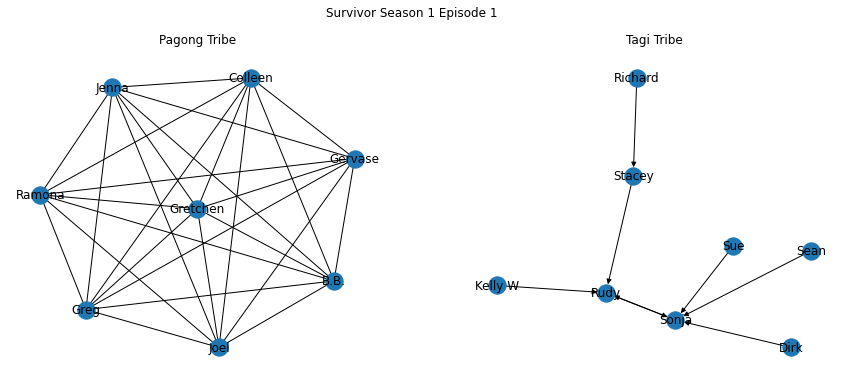

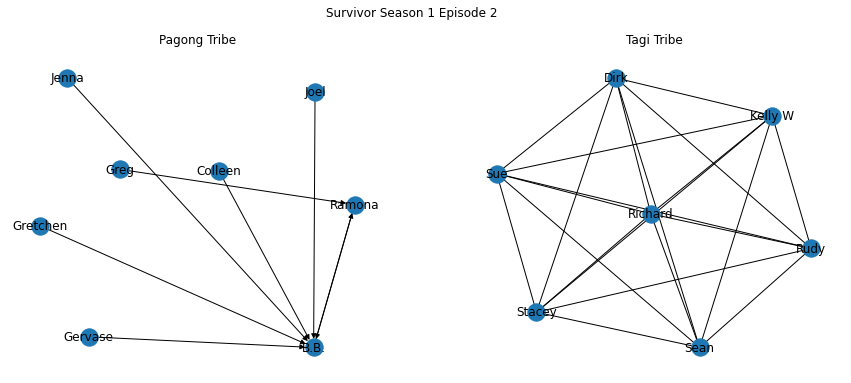

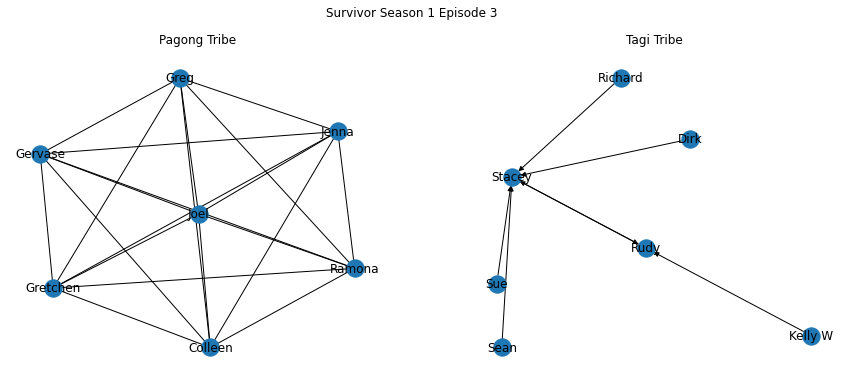

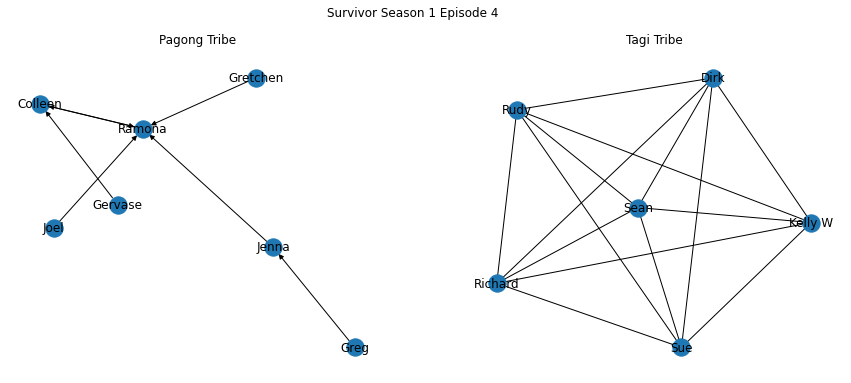

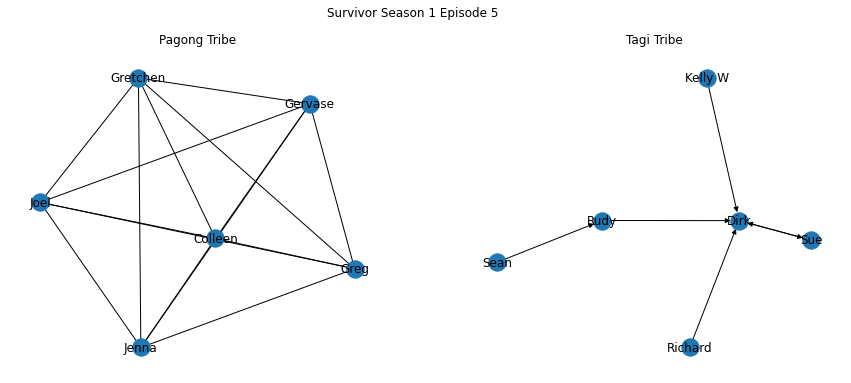

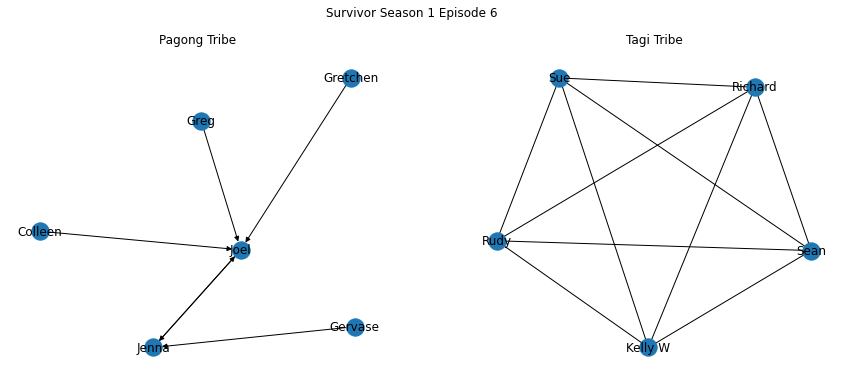

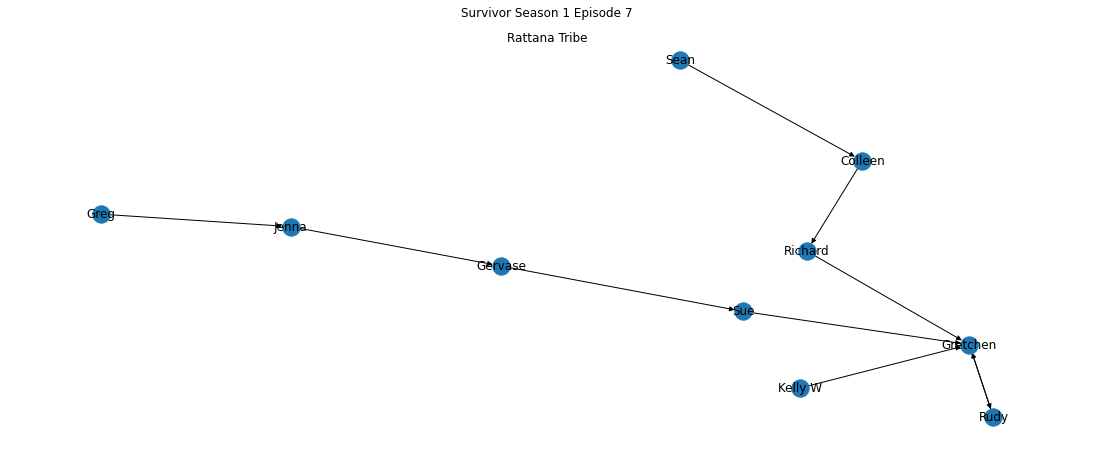

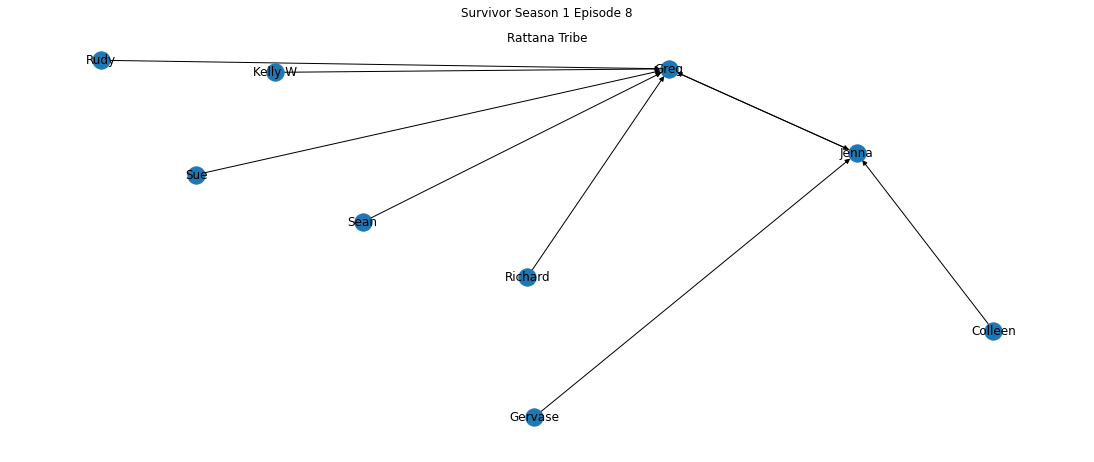

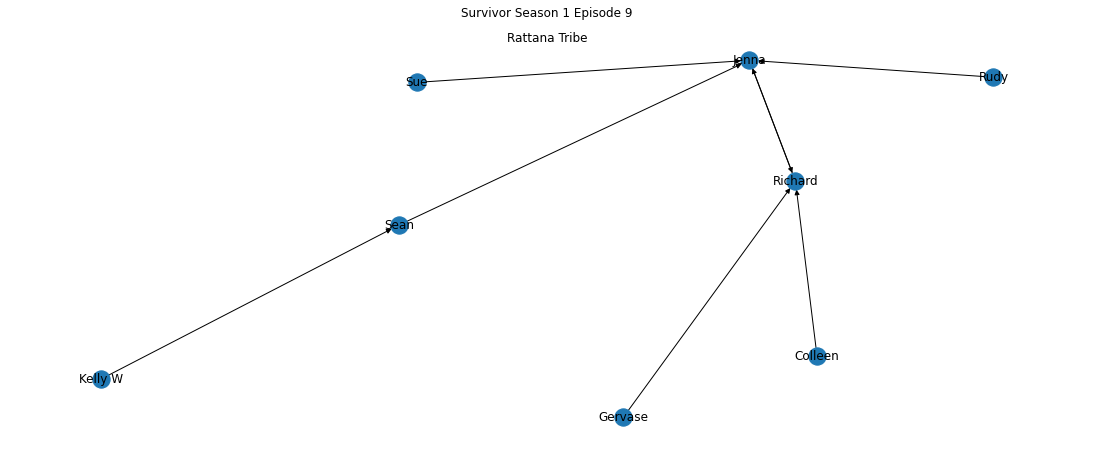

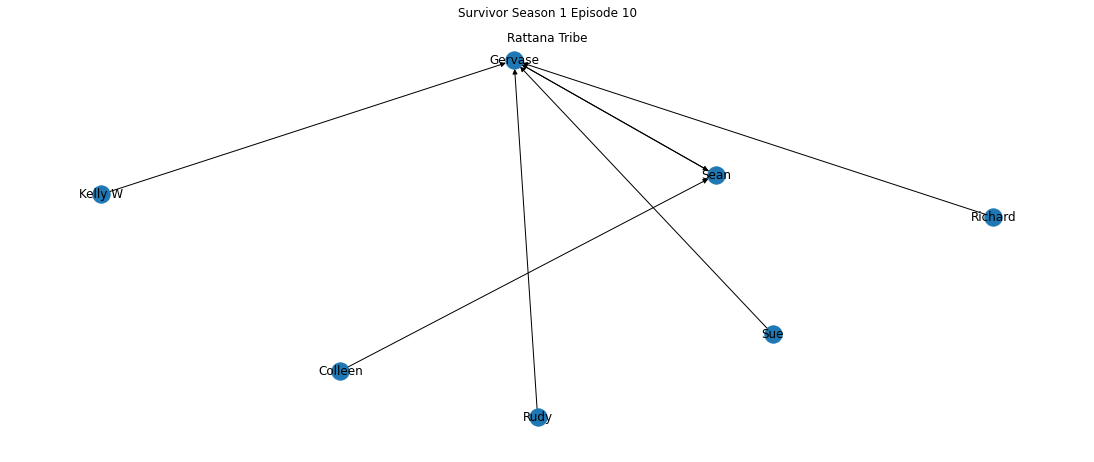

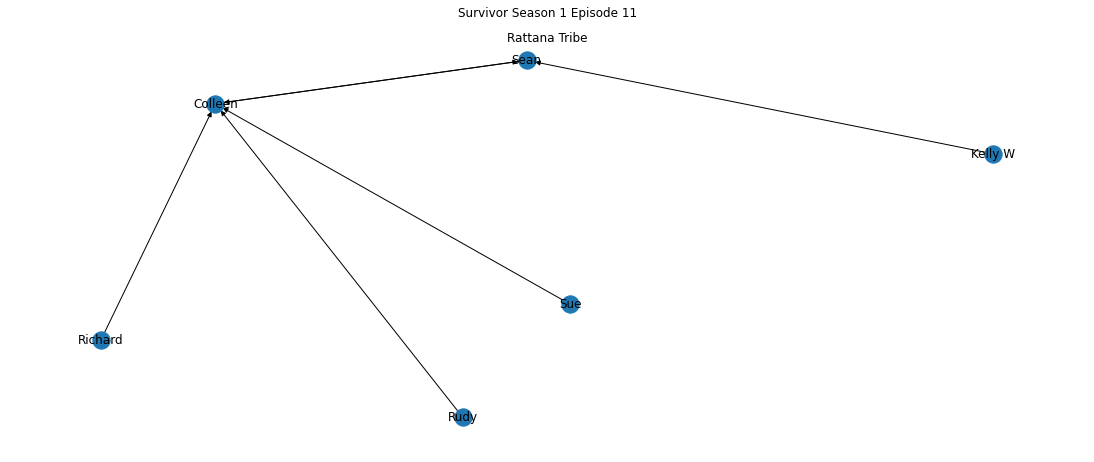

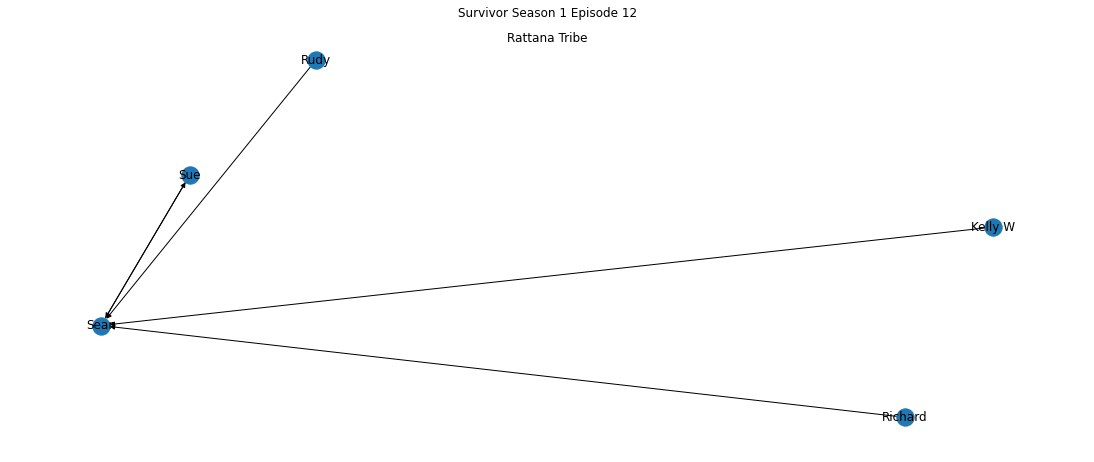

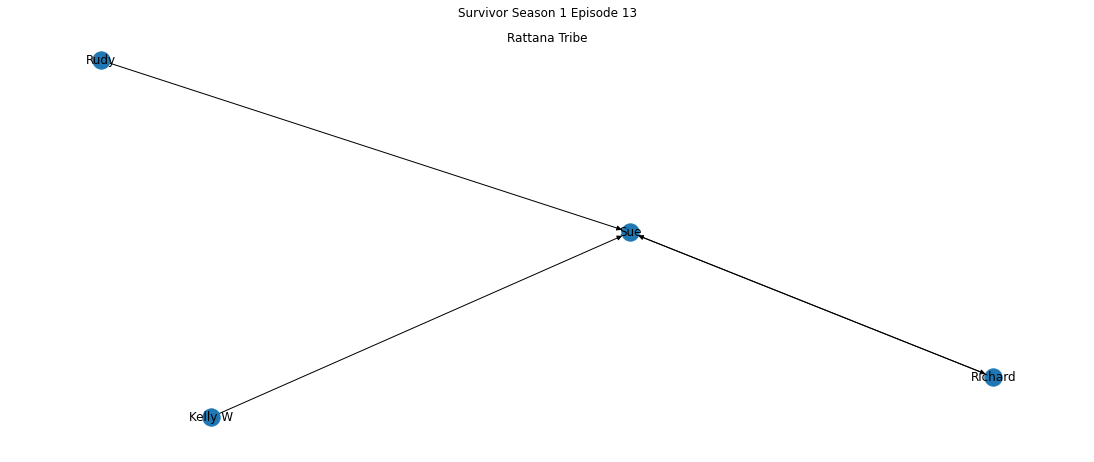

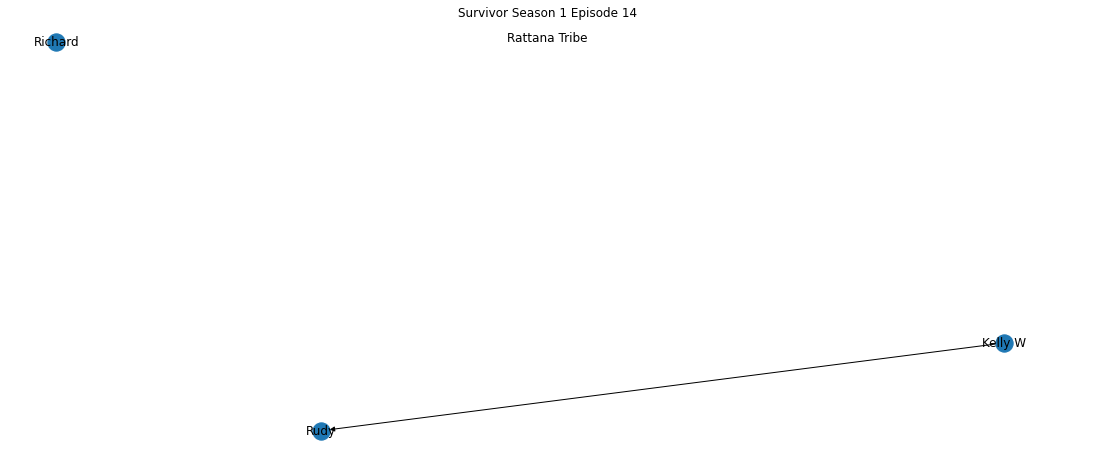

In [320]:
plotSeasonEpisodes(seasonstats)

In [360]:
def getNodeAttributes(seasonstats):
    f = seasonstats[seasonstats['Episode'] == 1][["Contestants","Sex","Age","Occupation","Home State", "Original Tribe"]]
    c = list(f.columns)[1:]
    
    attr = {}

    for i in range(len(f)):
        tmp = {}
        attr[f.iloc[i][0]] = tmp

        for j in range(len(c)):
            tmp[c[j]] = f.iloc[i][j+1] 
            
    return attr
    

In [361]:
attr = getNodeAttributes(seasonstats)

In [416]:
"""Tried to write a general function to add edge attributes but just got far enough for one hardcoded attribute"""
def getEdgeAttributes(G):
    attr1 = {}
    
    edat = list(G.edges)
    
    for i in range(len(edat)):
        tmp = {}
        attr1[edat[i]] = tmp

        df = seasonstats[seasonstats['Episode'] == 1][["Contestants","Age"]]
        agediff = abs(df[df["Contestants"] == edat[i][0]]["Age"].iloc[0]-df[df["Contestants"] == edat[i][1]]["Age"].iloc[0])

        tmp["Age Difference"] = agediff

    return attr1

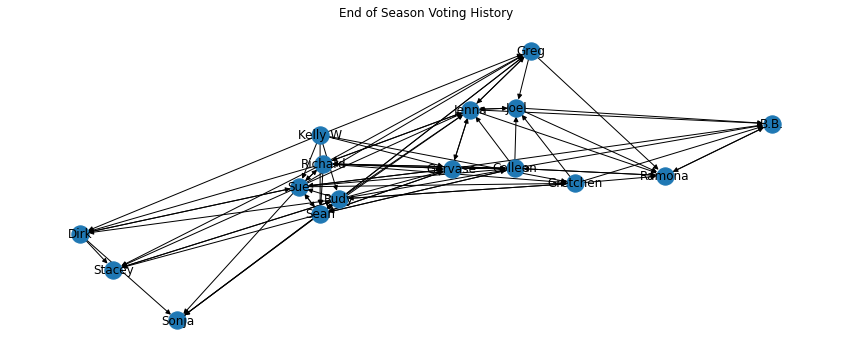

In [470]:
from collections import Counter

d = seasonstats[['Contestants','TCV']].dropna()
y = list(d.itertuples(index=False, name=None))
p = list(Counter(y).items())

attr = {}

for i in range(len(p)):
    tmp = {}
    attr[p[i][0]] = tmp

    tmp["NumVotes"] = p[i][1]
    

G = nx.DiGraph()

fig = plt.figure(figsize=(15, 6))

G.add_nodes_from(d["Contestants"].unique())
G.add_edges_from(y)
nx.set_edge_attributes(G, attr)
plt.title('End of Season Voting History')
nx.draw(G, with_labels=True)

"""Need to add number of votes that occured (in the edge attributes already) to the edge width"""